In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


read cleaned file

In [2]:
X = pd.read_csv("data clean 2.csv")
X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(object)
display(X_num.columns)
display(X_cat.columns)

Index(['querying', 'engineering', 'analysis', 'model_building', 'scraping',
       'dashboarding'],
      dtype='object')

Index(['job_title', 'comp_name', 'city'], dtype='object')

scaling the numerical data

In [3]:
scaler = MinMaxScaler().fit(X_num)
X_num_sc = scaler.transform(X_num)
X_num_sc = pd.DataFrame(X_num_sc, columns=X_num.columns)

In [4]:
plt.style.use('dark_background')

choosing a good number for clustering

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

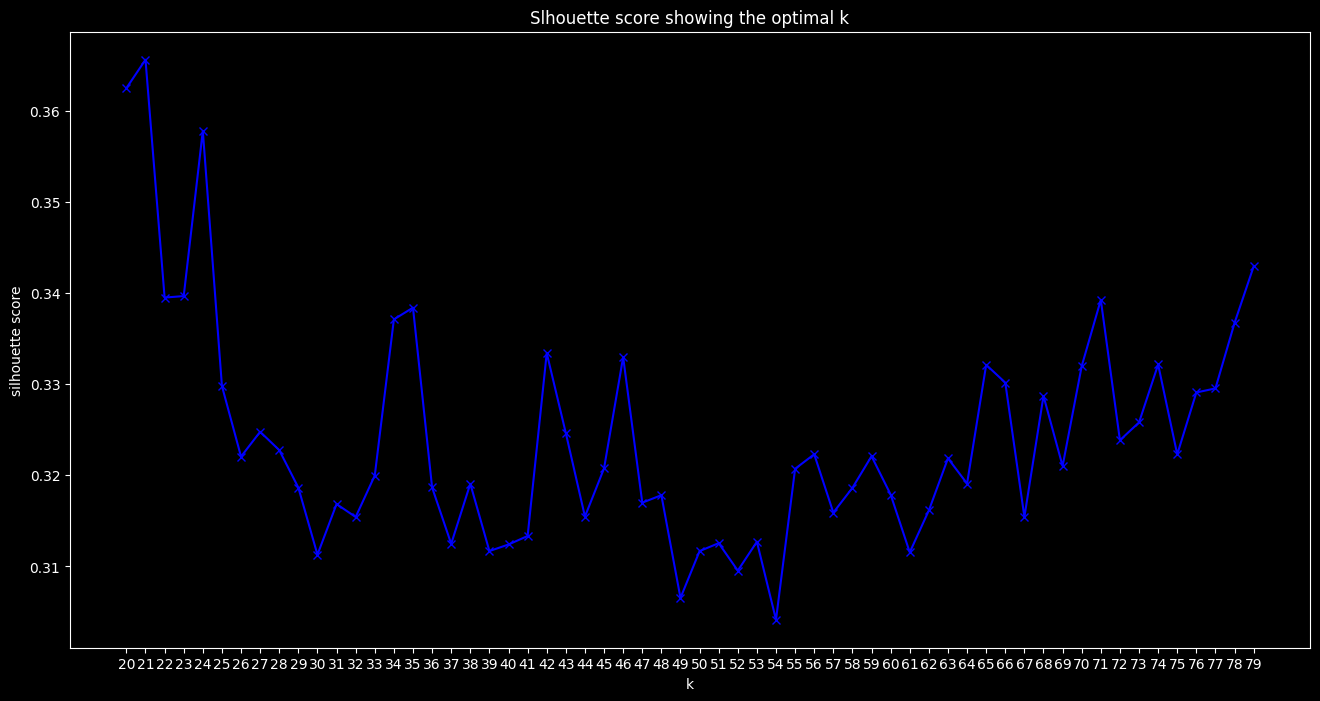

In [5]:
K = range(20,80)
silhouette = []

for k in K:
    kmeans = cluster.KMeans(n_clusters=k,
                    random_state=1234)
    # kmeans.fit(X)
    # silhouette.append(silhouette_score(X, kmeans.predict(X)))
    kmeans.fit(X_num_sc)
    silhouette.append(silhouette_score(X_num_sc, kmeans.predict(X_num_sc)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

adds a "total" column for total score. dropping rows that have too low score

In [6]:
X_num_sc["total"] = X_num_sc["querying"] + X_num_sc["engineering"] + X_num_sc["analysis"] + X_num_sc["model_building"] + X_num_sc["scraping"] + X_num_sc["dashboarding"]
X_num_sc = X_num_sc.drop(X_num_sc[X_num_sc["total"] < .2].index)
X_num_sc.head(1)

,querying,engineering,analysis,model_building,scraping,dashboarding,total
0,0.333293,0.333333,0.250027,0.25,0.4444,0.5455,2.156553


build model and get the prediction for each rows

In [7]:
kmeans = cluster.KMeans(n_clusters=37)
kmeans.fit(X_num_sc)
clusters = kmeans.predict(X_num_sc)
pred = kmeans.predict(X_num_sc).tolist()
X_num_sc["category"] = pred
X_cat = X_cat.reset_index(drop=True)
X = pd.concat([X_num_sc, X_cat], axis = 1)

checking heatmap

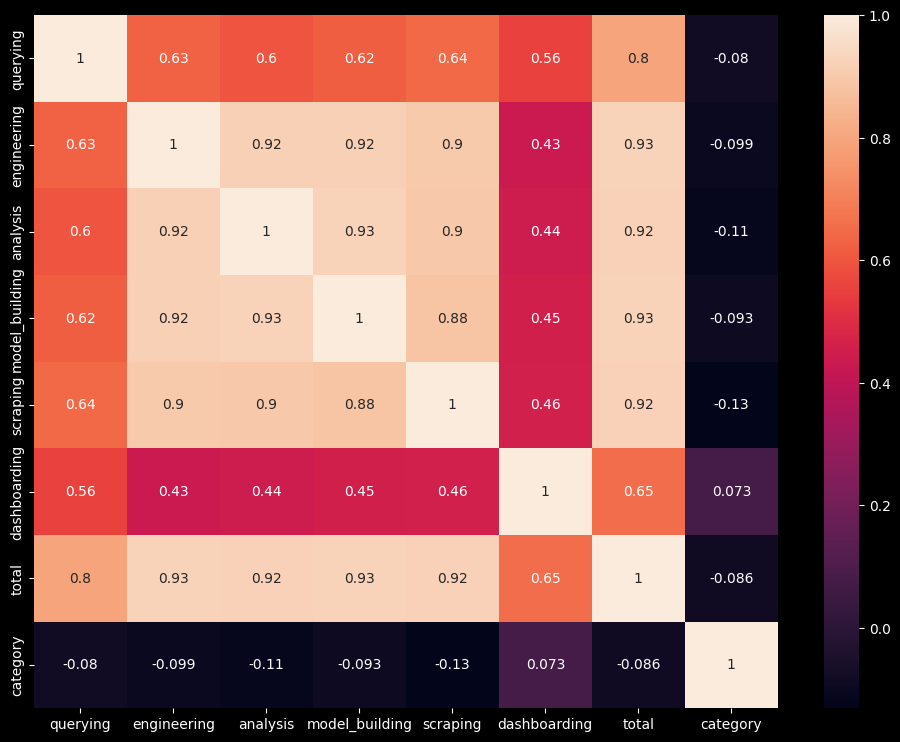

In [8]:
import seaborn as sns
df_corr = X.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(df_corr, annot=True)
plt.show()

In [9]:
import plotly.express as px
import plotly.graph_objects as go
import easygui as eg
import tqdm as tqdm

preparing options to be clicked in the user interface

In [10]:
opt1 = ["database queries","data extraction","logical query processing","database manipulation",
                "practical SQL operations","spark", "NoSQL"] #7
opt2 = ["deep learning","object-oriented-programming","natural language processing","building data pipeline",
        "ETL processes","AWS cloud","PySpark", "azure DevOps", "tensorflow"] #9
opt3 = ["data manipulation","exploratory data analysis","data remodeling","handling outliers",
        "inferential statistics, hypothesis testing","google analytics","statistic", "pivot table"] #7
opt4 = ["building regressor","building classifier","optimizing hyperparameter","clustering data",
        "feature selection","dimensionality reduction","analyzing imbalanced data"] #7
opt5 = ["web scraping","task simulation/automation","working with API","manipulating JSON data",
        "data cleaning","data entry"] #6
opt6 = ["tableau","power BI","dashboarding","making reports","presentation & communication",
        "team organization","ms excel power pivot","agile, scrum"] #8
opt = [opt1, opt2, opt3, opt4, opt5, opt6]

function to display the questionnaire using GUI

In [11]:
def question(option, num):
    question = "which of these tasks are you confident working on? ("+str(num)+"/6)"
    title = "search preferences"
    answer = eg.multchoicebox(question , title, option)
    df = pd.DataFrame(columns = option)
    value,score = [],[]
    for i in option:
        if i in answer:
            value.append(1)
    if len(value) != 0:
        score.append(len(value)/len(option))
    else:
        score.append(0)
    return score

get the answers as a series of scores stored in a single-lined dataframe

In [12]:
def get_answer(opt):
    df = pd.DataFrame(columns = ["querying","engineering","analysis","model_building","scraping","dashboarding"])
    i = 0
    for option, column in list(zip(opt,df.columns)):
        i = i+1
        df[column] = question(option,i)
    df["total"] = df.sum(axis = 1)
    return df

get random number to get a random row from the recommended cluster

In [13]:
import random
from random import randint
def getrandom(df):
    x = df.shape[0]
    x = random.randint(0,x)
    rec_job = df.iloc[x,:]
    return rec_job

executing the "get input" and "display output" at the same time

Recommended for you: Python Software Engineer - RF Validation Tools Development (m/f/d)


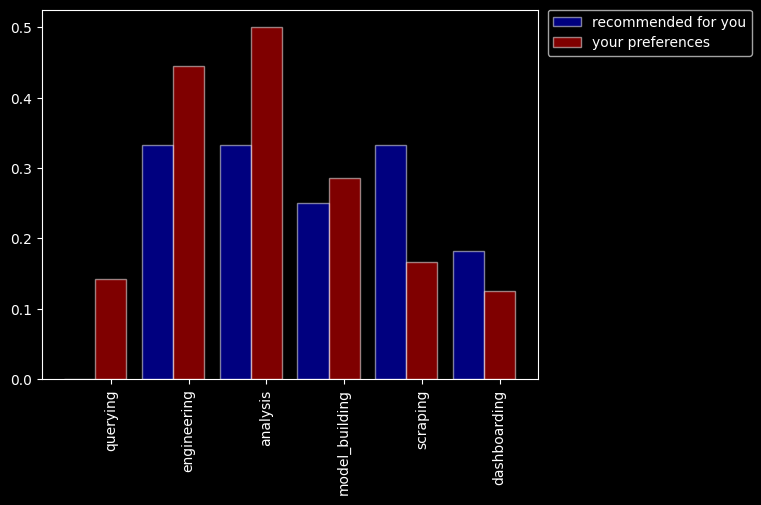

In [15]:
X_new = get_answer(opt)
pred_new = kmeans.predict(X_new).tolist()
X_new["category"] = pred_new
X_new["job_title"] = ["your preferences"]

selection = X[X["category"] == pred_new[0]]
recommendation = getrandom(selection)
recommendation = pd.DataFrame(recommendation).T

# https://www.geeksforgeeks.org/star-charts-in-python/
plt_vars = ["querying","engineering","analysis","model_building","scraping","dashboarding"]
print("Recommended for you:",recommendation.loc[(recommendation.loc[:,plt_vars].index.values.tolist()[0]),"job_title"])
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r = pd.Series(recommendation.loc[(recommendation.loc[:,plt_vars].index.values.tolist()[0]), plt_vars].values),
                theta = plt_vars, fill = "toself", name = "recommended for you"))
fig.add_trace(go.Scatterpolar(r = pd.Series(X_new.loc[0, plt_vars].values),
                theta = plt_vars, fill = "toself", name = "your skillset"))

fig.update_layout(polar=dict(radialaxis=dict(visible=True)),template="plotly_dark",showlegend=True)
fig.show()

barwidth= 0.4
bars1 = recommendation.iloc[0,0:6].values.tolist()
bars2 = X_new.iloc[0,0:6].values.tolist()
r1 = np.arange(len(bars1))
r2 = [x + barwidth for x in r1]
plt.bar(r1,bars1,color = "blue", width=barwidth,edgecolor="white",label="recommended for you", alpha=.5)
plt.bar(r2,bars2,color = "red", width=barwidth, edgecolor="white", label="your preferences", alpha=.5)
plt.xticks([r+barwidth for r in range(len(bars1))],recommendation.columns.tolist()[0:6], rotation = 90)
plt.legend(bbox_to_anchor=(1.02,1), loc = "upper left", borderaxespad=0)
plt.show()